# Managing Data and Working with Volumes

## Types of Data
1. Application (Code + Environment) -
    - **Read-only, hence stored in Images**
    - Written & provided by developer
    - Added to image & container in build phase
    - Can't be changed once image is built


2. Temporary App data (e.g. user input) -
    - **Read + write, temporary, hence stored in Containers**
    - Fetched/Produced in running container
    - Stored in memory or temporary files
    - Dynamic and changing
    
    
3. Permanent App Data (e.g. user accounts) -
    - **Read + write, permanent, hence stored with Containers & Volumes**
    - Fetched/Produced in running container
    - Stored in a database
    - Must not be lost if container stops/restarts

Docker containers are used to run applications in an isolated environment. By default, all the changes inside the container are lost when the container stops. If we want to keep data between runs, Docker volumes and bind mounts can help.

## Docker File System

- Images are made of a set of **read-only** layers that work on a file system called the Union File System. 
- When we start a new container, Docker adds a **read-write** layer on the top of the image layers allowing the container to run as though on a standard Linux file system.
- Any file change inside the container creates a working copy in the **read-write** layer. 
- However, when the container is stopped or deleted, that read-write layer is lost.


### Two Types of External Data Storages

1. **Volumes** (Managed by Docker)
    - 2 types -
        - Anonymous Volumes - only exists when container exists
        - Named Volumes - great for persistent data, but which you don't need to edit directly.
    - Docker sets up a folder/path on host machine, exact location is unknown to developer. 
    - Managed via ``` docker volume ``` commands.
    
    
2. **Bind Mounts** (Managed by You)

    - You define a folder/path on your host machine
    - Great for persistent, editable data.

A defined path in the container is mapped to the created volume/mount.

### Bind Mounts

A Bind Mount is a storage area (file or directory) on your local machine available inside your container. So any changes you make to this storage space (file or directory) from the outside container will be reflected inside the docker container and vice-versa.

The file or directory is referenced by its absolute path on the host machine. 

Bind mounts are very performant, but they rely on the host machine’s filesystem having a specific directory structure available.

*Please Note: A bind mount will overwrite the content of the docker container.*


A practical application of Bind Mounts can be when you want to update the source code of your image and run it inside the container without creating a new image. You can do so by creating a Bind Mount and changing the code from your local machine, which will then reflect in your container.

If you use -v or --volume to bind-mount a file or directory that does not yet exist on the Docker host, -v creates the endpoint for you. It is always created as a directory.

If you use --mount to bind-mount a file or directory that does not yet exist on the Docker host, Docker does not automatically create it for you, but generates an error.

**Activity:**
1. Create an empty directory on local machine
2. Access the conten of this directory at "/app/example" from withing container
    ``` 
    docker run -d --name devtest -v "%cd%":/app/example image_name
    ```
    or
    ```
    docker run -d -it --name devtest --mount type=bind,source="%cd%",target=/app image_name
    ```
3. Create file in example directory and check if it is available from inside the container
    ``` 
    docker exec -it bind-mount 
    ```
4. Create a file inside container and check if it is available on local machine
5. Delete the container and see if data persists on your local machine

### Volumes

Volumes are **folders on your host machine** which are **mounted** ("made available", mapped) **into containers**.
Volumes persist if a container shuts down or restarts.
A container can write data into a volume and read data from it.

Volumes are the preferred mechanism for persisting data generated by and used by Docker containers. While bind mounts are dependent on the directory structure and OS of the host machine, volumes are completely managed by Docker. 

Volumes have several advantages over bind mounts:
- Volumes are easier to back up or migrate than bind mounts.
- You can manage volumes using Docker CLI commands or the Docker API.
- Volumes work on both Linux and Windows containers.
- Volumes can be more safely shared among multiple containers.
- Volume drivers let you store volumes on remote hosts or cloud providers, to encrypt the contents of volumes, or to add other functionality.
- New volumes can have their content pre-populated by a container.
- Volumes on Docker Desktop have much higher performance than bind mounts from Mac and Windows hosts.

In addition, volumes are often a better choice than persisting data in a container’s writable layer, because **a volume does not increase the size of the containers using it, and the volume’s contents exist outside the lifecycle of a given container**.

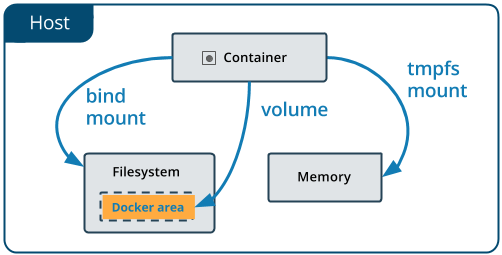

#### Create and Manage a Volume

Unlike a bind mount, you can create and manage volumes outside the scope of any container.

1. Create a Volume
```
docker volume create my-vol
```

2. List volumes:
```
docker volume ls
```
3. Inspect a volume:
``` 
docker volume inspect my-vol
[
    {
        "Driver": "local",
        "Labels": {},
        "Mountpoint": "/var/lib/docker/volumes/my-vol/_data",
        "Name": "my-vol",
        "Options": {},
        "Scope": "local"
    }
]
```

4. Remove a volume:
```
docker volume rm my-vol
```

### Start a container with a volume

If you start a container with a volume that doesn’t yet exist, Docker creates the volume for you. 

The following example mounts the volume into /app/ in the container.
```
docker run -d --name container_name -v volume_name:/app image_name:version
```
or
```
docker run -d --name container_name --mount source=volume_name,target=/app  image_name:version
```

### Choose the -v or --mount flag

In general, **--mount** is more explicit and verbose. The biggest difference is that the **-v** syntax combines all the options together in one field, while the **--mount** syntax separates them. Here is a comparison of the syntax for each flag.

If you need to specify volume driver options, you must use **--mount**.

* -v or --volume: 
    - Consists of three fields, separated by colon characters (:). The fields **must be in the correct order**, and the meaning of each field is not immediately obvious.
    - In the case of named volumes, *the first field is the name of the volume*, and is unique on a given host machine. For anonymous volumes, the first field is omitted.
    - The *second field is the path* where the file or directory are mounted in the container.
    - The third field is optional, and is a *comma-separated list of options, such as ro.*.
    
* --mount: 
    - Consists of multiple key-value pairs, separated by commas and each consisting of a <key>=<value> tuple. 
    - The --mount syntax is more verbose than -v or --volume, but the **order of the keys is not significant**, and the value of the flag is easier to understand.
    - The type of the mount, which can be bind, volume, or tmpfs.
    - The source of the mount. For named volumes, this is the name of the volume. For anonymous volumes, this field is omitted. May be specified as source or src.
    - The destination takes as its value the path where the file or directory is mounted in the container. May be specified as destination, dst, or target.
    - The readonly option, if present, causes the bind mount to be mounted into the container as read-only. May be specified as readonly or ro.
    - The volume-opt option, which can be specified more than once, takes a key-value pair consisting of the option name and its value.

### Read-only volume

Multiple containers can mount the same volume. You can simultaneously mount a single volume as read-write for some containers and as read-only for others.

The following example modifies the one above but mounts the directory as a read-only volume, by adding ro to the (empty by default) list of options, after the mount point within the container.
```
docker run -d --name=conatiner_name -v volume_name:/dest/path/to/vol:ro image_name:version
```

### Share data between machines

When building fault-tolerant applications, you may need to configure multiple replicas of the same service to have access to the same files.

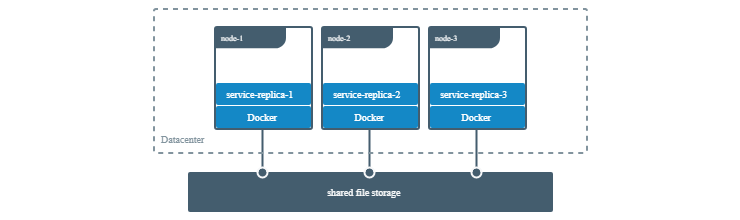